In [2]:
# 基礎
import pandas as pd
import numpy as np
import math
import json
import os
import jieba  ## 斷字
jieba.set_dictionary('dict.txt.big')
stopwords = [ line.rstrip() for line in open('stops.txt' , encoding='utf8') ] ## 這個中文停用字典可以自己找

# 視覺化
import matplotlib.pyplot as plt  ## python最常見的繪圖工具
import matplotlib
zhfont1 = matplotlib.font_manager.FontProperties(fname='simsun.ttf')  ## plt中文字
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA  ## 降維視覺化常用工具
from pylab import rcParams  ## 調整畫布比例

# 訓練模型
from sklearn.model_selection import train_test_split  ## 切分鍊與測試資料集
from sklearn.neighbors import KNeighborsClassifier  ## KNN
from sklearn.svm import SVC  ## SVM
from  xgboost import XGBClassifier  ## xgboost
import xgboost

# 從新竹社會局常見問答集爬取
def getdata():
    with open('RawData.json', 'r', encoding='utf8') as f:
        data = json.load(f)
    df = pd.DataFrame(data)
    return df

In [3]:
#Load Data 這是預先爬下的資料

df_train = getdata()
print("Rows=", len(df_train))
df_train.head()

Rows= 327


,ans,cat,id,question
0,1.幼兒家長在戶政事務所完成新生兒出生登記後，即可向所轄區公所社政課提出育兒津貼申請。2.在...,幼兒福利及托育服務,189,小孩出生後應於何時申請育兒津貼?
1,隨時提出;津貼經審查通過後，追溯自受理申請之當月起發給。兒童出生後六十日內向戶政事務所完成出...,幼兒福利及托育服務,189,小孩出生後應於何時申請育兒津貼?
2,申請資料應備齊:(一)兒童之戶口名簿影本。(二)申請人之郵局存摺封面影本。(三)父母雙方身分...,幼兒福利及托育服務,189,育兒津貼申請應備文件為何?
3,一、育兒津貼補助對象：1.育有二足歲以下兒童。2.兒童之父母至少一方因育兒需要，致未能就業者...,幼兒福利及托育服務,189,若民眾夫妻雙方均失業，是否可申請家庭育兒津貼費用補助
4,育兒津貼補助對象，應符合下列規定：(一)育有二足歲以下兒童。(二)兒童之父母(或監護人)至少...,幼兒福利及托育服務,189,育兒津貼補助對象為何？


In [4]:
# 斷字
def preprocess(question):
#     words = list(jieba.cut(question)) ## 精準模式
    words = list(jieba.cut(question, cut_all=True)) ## 全斷詞模式
    return words
df_train['words'] = df_train['question'].apply(preprocess)
df_train.head()

Building prefix dict from C:\Users\02445\dict.txt.big ...
Dumping model to file cache C:\Users\02445\AppData\Local\Temp\jieba.u9559bedd98d8d417e0d70414c1420459.cache
Loading model cost 1.026 seconds.
Prefix dict has been built succesfully.


,ans,cat,id,question,words
0,1.幼兒家長在戶政事務所完成新生兒出生登記後，即可向所轄區公所社政課提出育兒津貼申請。2.在...,幼兒福利及托育服務,189,小孩出生後應於何時申請育兒津貼?,"[小孩, 出生, 後, 應, 於, 何時, 申請, 育兒, 津貼, , ]"
1,隨時提出;津貼經審查通過後，追溯自受理申請之當月起發給。兒童出生後六十日內向戶政事務所完成出...,幼兒福利及托育服務,189,小孩出生後應於何時申請育兒津貼?,"[小孩, 出生, 後, 應, 於, 何時, 申請, 育兒, 津貼, , ]"
2,申請資料應備齊:(一)兒童之戶口名簿影本。(二)申請人之郵局存摺封面影本。(三)父母雙方身分...,幼兒福利及托育服務,189,育兒津貼申請應備文件為何?,"[育兒, 津貼, 申請, 應, 備, 文件, 為何, , ]"
3,一、育兒津貼補助對象：1.育有二足歲以下兒童。2.兒童之父母至少一方因育兒需要，致未能就業者...,幼兒福利及托育服務,189,若民眾夫妻雙方均失業，是否可申請家庭育兒津貼費用補助,"[若, 民眾, 夫妻, 雙方, 均, 失業, , , 是否, 可, 申請, 家庭, 育兒, ..."
4,育兒津貼補助對象，應符合下列規定：(一)育有二足歲以下兒童。(二)兒童之父母(或監護人)至少...,幼兒福利及托育服務,189,育兒津貼補助對象為何？,"[育兒, 津貼, 貼補, 補助, 對象, 為何, , ]"


In [5]:
#準備把文字類別轉換成數字類別

# 為了訓練需要，將類別轉化為數字類別(1~11類)
cat_mapping = {}
for num, cat in enumerate(list(set(df_train['cat']))):
    cat_mapping[cat] = num
    
# 預測時，要將預測出的結果翻譯為原先的類別所使用
inversed_cat_mapping = {}
for cat, idx in cat_mapping.items():
    inversed_cat_mapping[idx] = cat

print(cat_mapping)
print(inversed_cat_mapping)

{'幼兒福利及托育服務': 0, '婦女福利': 1, '身心障礙者福利': 2, '兒童少年及家庭福利': 3, '社區發展服務': 4, '社工專業服務': 5, '志願服務': 6, '人民團體及合作社場服務': 7, '社會救助': 8, '家庭暴力及性侵害防治服務': 9, '國民年金': 10, '老人福利': 11}
{0: '幼兒福利及托育服務', 1: '婦女福利', 2: '身心障礙者福利', 3: '兒童少年及家庭福利', 4: '社區發展服務', 5: '社工專業服務', 6: '志願服務', 7: '人民團體及合作社場服務', 8: '社會救助', 9: '家庭暴力及性侵害防治服務', 10: '國民年金', 11: '老人福利'}


In [7]:
#添加類別本身當作問題，以增強簡短問題的回答能力
#後來在測試預測能力時，發現如果使用者只透過幾個簡單的字詢問，將有可能導致預測失準，因為從社會處爬下來的每個問題都是完整的問句，因此增加這樣的資料，將有助於使用者使用簡短的特定議題標題，作為詢問問題。

print('Preprocess Length = ', len(df_train))

addedrow = []
for key, value in cat_mapping.items():
    row = {}
    words = list(jieba.cut(key, cut_all=False))
    row['words'] = words
    
    row = {'ans': None,
            'cat': key,
            'cat_num': value,
            'id': None,
            'question': key,
            'words':words
          }
    addedrow.append(row)
addeddf = pd.DataFrame(addedrow)
df_train = pd.concat([df_train, addeddf], sort=False)
print('Processed Length = ', len(df_train))

Preprocess Length =  339
Processed Length =  351


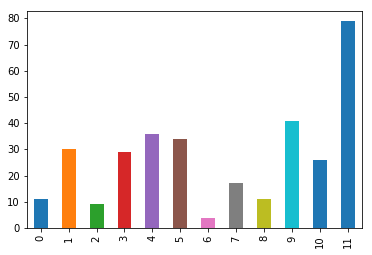

A 人民團體及合作社場服務 11
B 兒童少年及家庭福利 30
C 國民年金 9
D 婦女福利 29
E 家庭暴力及性侵害防治服務 36
F 幼兒福利及托育服務 34
G 志願服務 4
H 社區發展服務 17
I 社工專業服務 11
J 社會救助 41
K 老人福利 26
L 身心障礙者福利 79


In [10]:
'''
資料描述

每個類別的問題個數

這個部分很重要，因為訓練出來的類別分配比例，與訓練資料集內部的類別分配比例會相同，
因此如果未來使用者詢問的問題的比例與這個比例不同，將很有可能導致預測的失準，因此這部分要特別注意。
如果知道真實的使用者詢問比例，可以複製特定比例的資料以平衡比例。
'''

main_series = df_train.groupby('cat').count()['ans']
main_series.plot(kind='bar', use_index=False)
plt.savefig(os.path.join('pic', 'nums_of_queries_each_cat'))
plt.show()

for i in range(len(list(main_series.index))):
    label = 'ABCDEFGHIJKLMNOPQRSTU'
    print(label[i], main_series.index[i], list(main_series)[i])

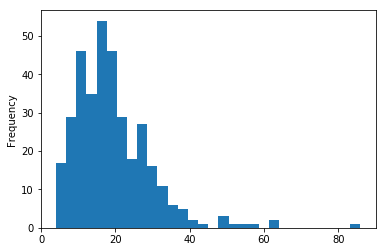

In [11]:
#每個問題的長度
df_train['question'].apply(len).plot(kind='hist', bins=30)
plt.savefig(os.path.join('pic', 'length_of_queries'))
plt.show()

幼兒福利及托育服務


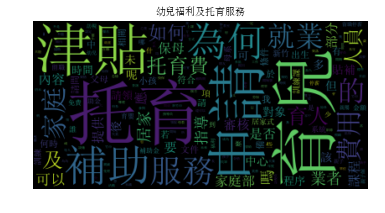

婦女福利


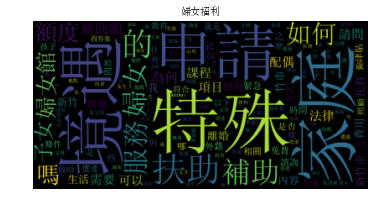

身心障礙者福利


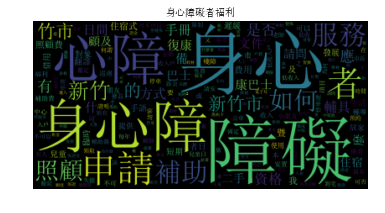

兒童少年及家庭福利


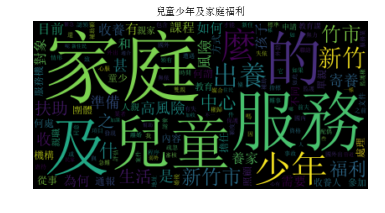

社區發展服務


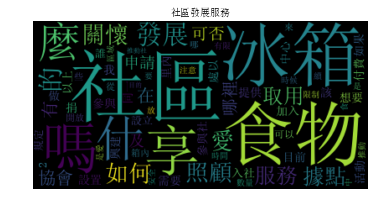

社工專業服務


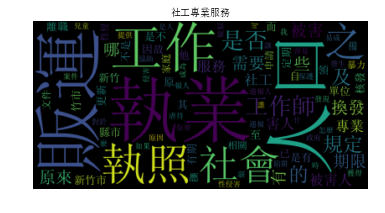

志願服務


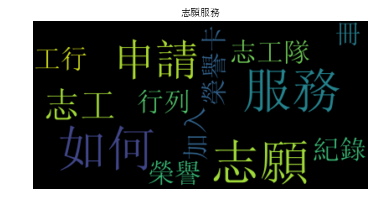

人民團體及合作社場服務


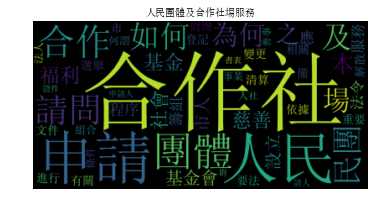

社會救助


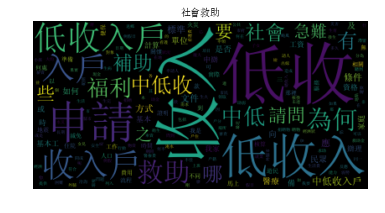

家庭暴力及性侵害防治服務


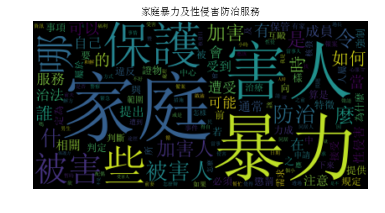

國民年金


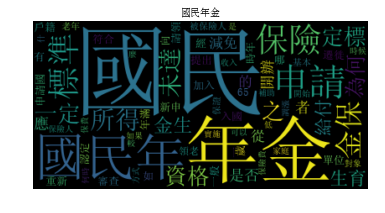

老人福利


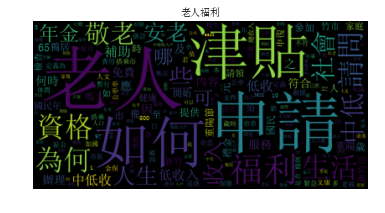

In [12]:
#每個類別的常用字
#這個步驟可以看出，每個類別比較常用的一些字，如果可以很明顯區辨，那麼訓練起來也就會比較容易，
#我剛開始拿到這個資料集準備要訓練時，看到這麼鮮明的類別詞彙，我就有滿高的把握，可以訓練起來的。

# 每個類別常出現的字
from wordcloud import WordCloud
from collections import Counter

freqs = []
for cat in list(set(df_train['cat'])):
    words_Li = list(df_train[df_train['cat'] == cat]['words'])
    total_words_in_cat = []
    for words in words_Li:
        total_words_in_cat.extend(words)
    freq = Counter(total_words_in_cat)
    print(cat)
    wordcloud = WordCloud(font_path="simsun.ttf")
    wordcloud.generate_from_frequencies(frequencies=freq)
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(cat, fontproperties=zhfont1)
    plt.savefig(os.path.join('pic', 'wordcloud_' + cat), bbox_inches='tight', pad_inches=0)
    plt.show()

In [13]:
#準備訓練資料
#把句子向量化
#這個步驟首先要先建立一個一致的詞彙索引list，如此將可以讓每一個問題，在同樣的向量下，增加出現的字所在的索引值的維度的值，以向量化所有問題。

# 準備排序的文字list(keywordindex)
total_li = []
for li in list(df_train['words']):
    total_li += li
vectorterms = list(set(total_li))

## 轉化每個問題變成向量
def vectorize(words):
    self_main_list = [0] * len(vectorterms)
    for term in words:
        if term in vectorterms:  ## 測試資料集當中的字不一定有出現在訓練資料集中
            idx = vectorterms.index(term)
            self_main_list[idx] += 1
    return np.array(self_main_list)

X = np.concatenate(df_train['words'].apply(vectorize).values).reshape(-1, len(vectorterms))
Y = df_train['cat'].apply(cat_mapping.get)
print(X.shape)
print(Y.shape)

(351, 1018)
(351,)


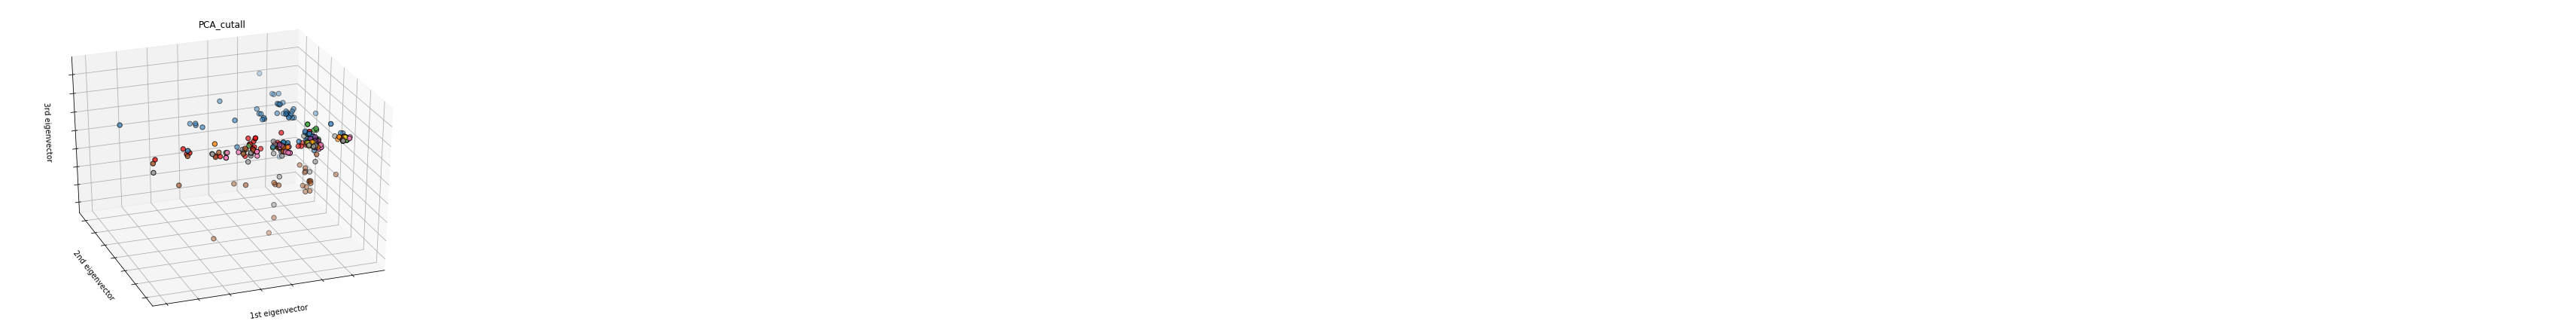

In [16]:
'''
查看訓練資料的資料分布
這個步驟很重要，我原本在jeiba斷字的階段，開的是精準模式，而不是全斷字模式，
那麼會得到右邊的結果，而這樣資料的極端分布，將會導致不好的訓練效果，因此這個步驟還是很必要的。
一旦發現資料的分佈有問題，可能要平滑處理一下特定的欄位，或是思考一下其他處理方式。
'''

fig = plt.figure(1, figsize=(8, 6))
ax = Axes3D(fig, elev=-150, azim=110)

X_reduced = PCA(n_components=3).fit_transform(X)
ax.scatter(X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2], c=Y,
           cmap=plt.cm.Set1, edgecolor='k', s=40)
ax.set_title("PCA_cutall")
ax.set_xlabel("1st eigenvector")
ax.w_xaxis.set_ticklabels([])
ax.set_ylabel("2nd eigenvector")
ax.w_yaxis.set_ticklabels([])
ax.set_zlabel("3rd eigenvector")
ax.w_zaxis.set_ticklabels([])

plt.savefig(os.path.join('pic', 'PCA_cutall'))
plt.show()

In [17]:
#切分訓練與測試資料
#為了避免overfitting，因此最好只拿一部分資料進去訓練模型，另一部分拿來驗證模型。

# Finally, we split some of the data off for validation
X_train, X_valid, Y_train, Y_valid = train_test_split(X, Y, test_size=0.2, random_state=123)

print(X_train.shape)
print(X_valid.shape)
print(Y_train.shape)
print(Y_valid.shape)

(280, 1018)
(71, 1018)
(280,)
(71,)


In [38]:
'''
開始訓練
KNN, SVM(rbf), SVM(linear), XGB(non CV)
先用幾個簡單的分類模型試試，其中你會發現，KNN在這種文字次數累積的稀疏矩陣(有很多零的向量)效果其實已經還不錯；
在SVM上因為rbf的函數無法有效解釋這些類別的差異，linear的效果則特別好；
另外XGB上的效果也不錯，主要原因是XGB是非常暴力的工具，某種曾度上撇除了參數調整的因素，不管怎麼用效果都特別好。
不過因為訓練資料量其實不大，因此有可能各位執行的時候，結果跟我並不太一樣。
'''

# 定義函式，輸入分類器，輸出準確率
def get_accuracy(clf, *args):
    if args:
        clf = clf(kernel=args[0])  ## SVM在這邊用Llinear比較準
    else:
        clf = clf()
    clf = clf.fit(X_train, Y_train)
    y_pred = clf.predict(X_valid)
    return (str(sum(Y_valid == y_pred)/Y_valid.shape[0]))

print('KNN: ', get_accuracy(KNeighborsClassifier))
print('SVM_rbf: ', get_accuracy(SVC))
print('SVM_linear: ', get_accuracy(SVC, 'linear'))
print('XGB: ', get_accuracy(XGBClassifier))

# KNN:  0.602941176471
# SVM_rbf:  0.220588235294
# SVM_linear:  0.838235294118
# XGB:  0.897058823529

KNN:  0.6338028169014085


D:\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVM_rbf:  0.23943661971830985
SVM_linear:  0.8732394366197183
XGB:  0.8873239436619719


In [39]:
#XGB + CV
#最後，我最喜歡使用的分類王者XGB+CV，由於可以自動開啟訓練的過程，使用上整個非常方便，也得到了最好的效果。

params = {}
params['objective'] = 'multi:softmax'  ## 因為是多個類別，這邊跟前面兩個類別的使用不太一樣
params['eta'] = 0.1
params['max_depth'] = 3
params['silent'] = 1
params['nthread'] = 4
params['num_class'] = len(set(Y))  ## 多個類別，記得要告訴她有幾個類別

d_train = xgboost.DMatrix(X_train, label=Y_train)
d_valid = xgboost.DMatrix(X_valid, label=Y_valid)
watchlist = [(d_train, 'train'), (d_valid, 'valid')]

bst = xgboost.train(params, d_train, 1000, watchlist, early_stopping_rounds=100, verbose_eval=10)

[0]	train-merror:0.160714	valid-merror:0.225352
Multiple eval metrics have been passed: 'valid-merror' will be used for early stopping.

Will train until valid-merror hasn't improved in 100 rounds.
[10]	train-merror:0.082143	valid-merror:0.126761
[20]	train-merror:0.075	valid-merror:0.112676
[30]	train-merror:0.05	valid-merror:0.098592
[40]	train-merror:0.046429	valid-merror:0.098592
[50]	train-merror:0.042857	valid-merror:0.098592
[60]	train-merror:0.028571	valid-merror:0.112676
[70]	train-merror:0.025	valid-merror:0.112676
[80]	train-merror:0.017857	valid-merror:0.112676
[90]	train-merror:0.017857	valid-merror:0.112676
[100]	train-merror:0.014286	valid-merror:0.112676
[110]	train-merror:0.014286	valid-merror:0.112676
[120]	train-merror:0.014286	valid-merror:0.112676
Stopping. Best iteration:
[26]	train-merror:0.067857	valid-merror:0.098592



In [40]:
#從結果上來看，測試資料可以達到88%的準確率，整個資料集來看，可以達到96%的準確率，效果還不錯。

y_pred = bst.predict(xgboost.DMatrix(X_valid))
print("Accuracy_valid: ", str(sum(Y_valid == y_pred)/Y_valid.shape[0]))
y_pred = bst.predict(xgboost.DMatrix(X))
print("Accuracy_all: ", str(sum(Y == y_pred)/Y.shape[0]))

Accuracy_valid:  0.8873239436619719
Accuracy_all:  0.9658119658119658


In [ ]:
'''
這邊其實也可以看一下，他的樹狀圖是怎麼畫的，不過沒什麼特別的意義就是了。
要使用這功能要先安裝graphviz，要下載有點久，大家斟酌使用。
'''

rcParams['figure.figsize'] = 10, 20
xgboost.plot_tree(bst, num_trees=2)
plt.savefig(os.path.join('pic', 'tree'))
plt.show()

In [42]:
#預測
#Load Data
#為了讓預測可以被檢驗，我們爬下台北市政府社會處的常見問答集來做測試。

# This is crawled from 台北社會局常見問答集
with open('Taipei_Society_Affiar_QA', 'r', encoding='utf8') as f:
    testing_questions = eval(f.read())
    testing_questions = np.random.choice(testing_questions, size=len(testing_questions))
    
df_test = pd.DataFrame(testing_questions, columns=['question'])
df_test.head()

,question
0,疑似患精神疾病、身心障礙或失智的老人於街上遊蕩而無人照顧。\r\n
1,月初持敬老悠遊卡至捷運站查詢機查詢每月免費點數，但點數顯示為O，為什麼？
2,申請台北卡-敬老、愛心乘車證服務(原敬老、愛心及愛心陪伴悠遊卡)資格為何？敬老悠遊卡年滿 6...
3,我的投保單位(特別是公司)如果已經倒閉以致無法取得老人健保自付額之繳費證明應該怎麼辦?(或是...
4,身心障礙者購買停車位貸款利息補貼的申請資格有哪些?


In [44]:
#預測
def predict(question):  ## 定義預測函數
    words = preprocess(question)
    vector = vectorize(words)
    cat_num = bst.predict(xgboost.DMatrix(vector.reshape(1, -1)))
    return inversed_cat_mapping.get(cat_num[0])
df_test['cat_pred'] = df_test['question'].apply(predict)
df_test[['question', 'cat_pred']].head()

,question,cat_pred
0,疑似患精神疾病、身心障礙或失智的老人於街上遊蕩而無人照顧。\r\n,身心障礙者福利
1,月初持敬老悠遊卡至捷運站查詢機查詢每月免費點數，但點數顯示為O，為什麼？,老人福利
2,申請台北卡-敬老、愛心乘車證服務(原敬老、愛心及愛心陪伴悠遊卡)資格為何？敬老悠遊卡年滿 6...,婦女福利
3,我的投保單位(特別是公司)如果已經倒閉以致無法取得老人健保自付額之繳費證明應該怎麼辦?(或是...,婦女福利
4,身心障礙者購買停車位貸款利息補貼的申請資格有哪些?,身心障礙者福利


In [45]:
#視訓練資料集的錯誤預測
df_train_error = df_train[['question', 'cat']]
df_train_error['cat_pred'] = df_train_error['question'].apply(predict)
df_train_error.loc[df_train_error['cat'] != df_train_error['cat_pred'], ['question', 'cat', 'cat_pred']]

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,question,cat,cat_pred
31,如何查詢新竹巿親子館「新手父母教室」的課程內容及上課時間?如何報名,幼兒福利及托育服務,老人福利
59,收養人親職準備教育課程內容?參加課程的幫助是甚麼？,兒童少年及家庭福利,老人福利
107,如何申請老花眼鏡、拐杖補助？,老人福利,身心障礙者福利
112,如何參加長青學苑課程？,老人福利,志願服務
149,家庭總收入應計算人口？,身心障礙者福利,兒童少年及家庭福利
227,家庭總收入包括哪些？,社會救助,家庭暴力及性侵害防治服務
232,請問在地行動服務提供哪些服務?申請資格?申請方式?,社會救助,身心障礙者福利
236,四大津貼一級一審,社會救助,老人福利
279,家庭暴力、性侵害及兒童虐待通報人是否可獲得保護及保密?,社工專業服務,家庭暴力及性侵害防治服務
314,如何加入志工行列？,志願服務,身心障礙者福利


In [47]:
#自己輸入問題的預測
query = input("請輸入你的問題?\n")
predict(query)

請輸入你的問題?
社會


'社會救助'